현재 작업 디렉토리: d:\3차 팀PJ\Old_team_project3-1\dy_data


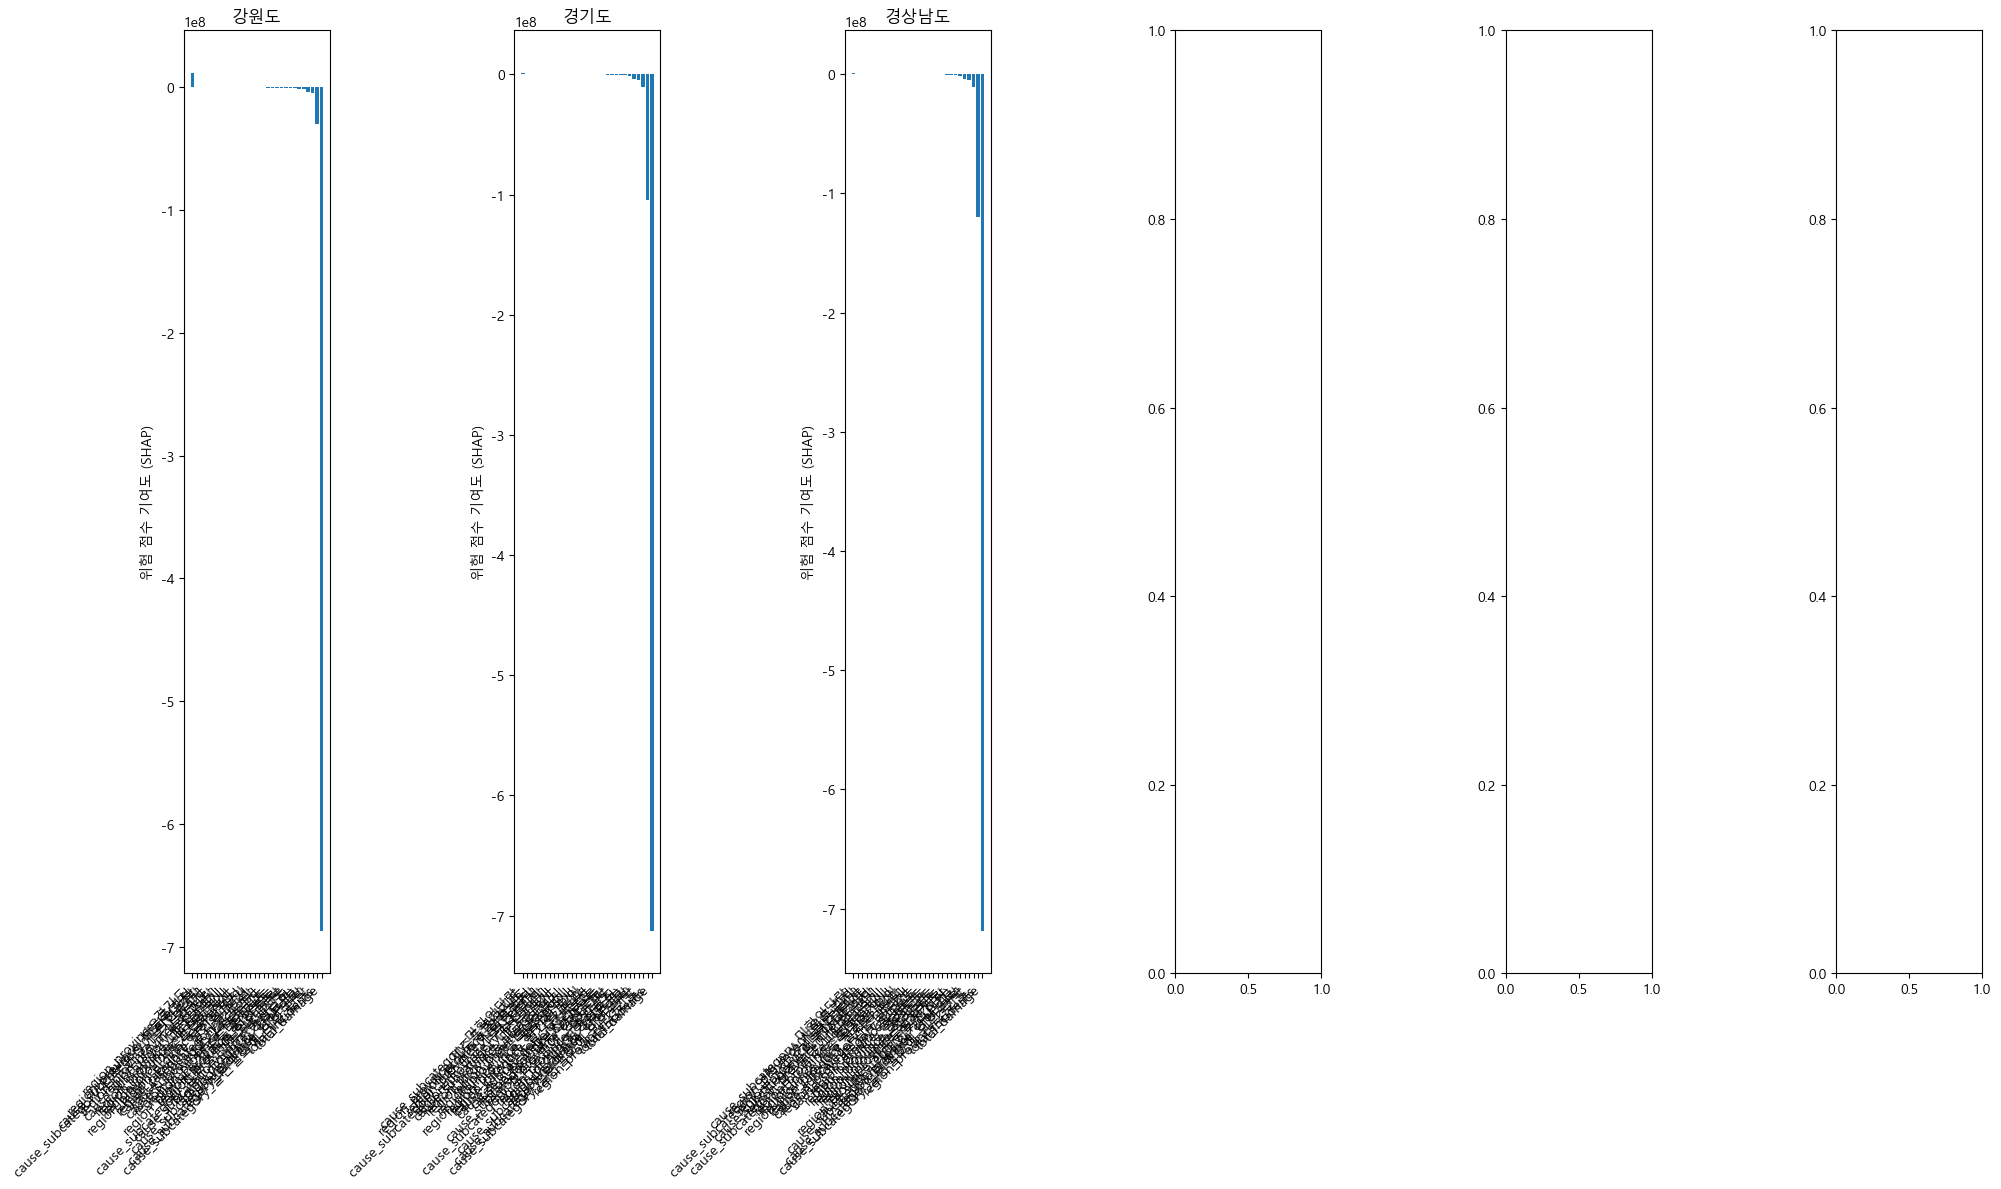

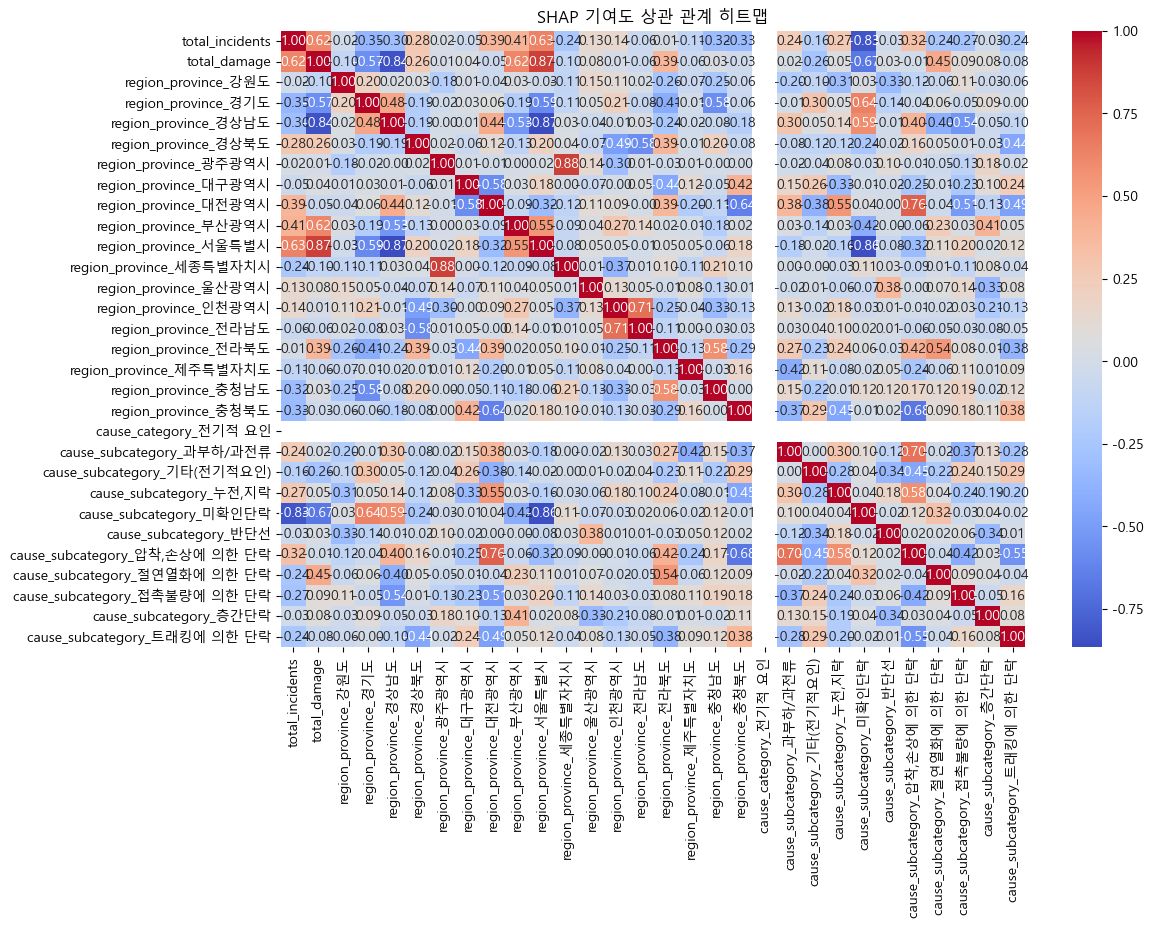

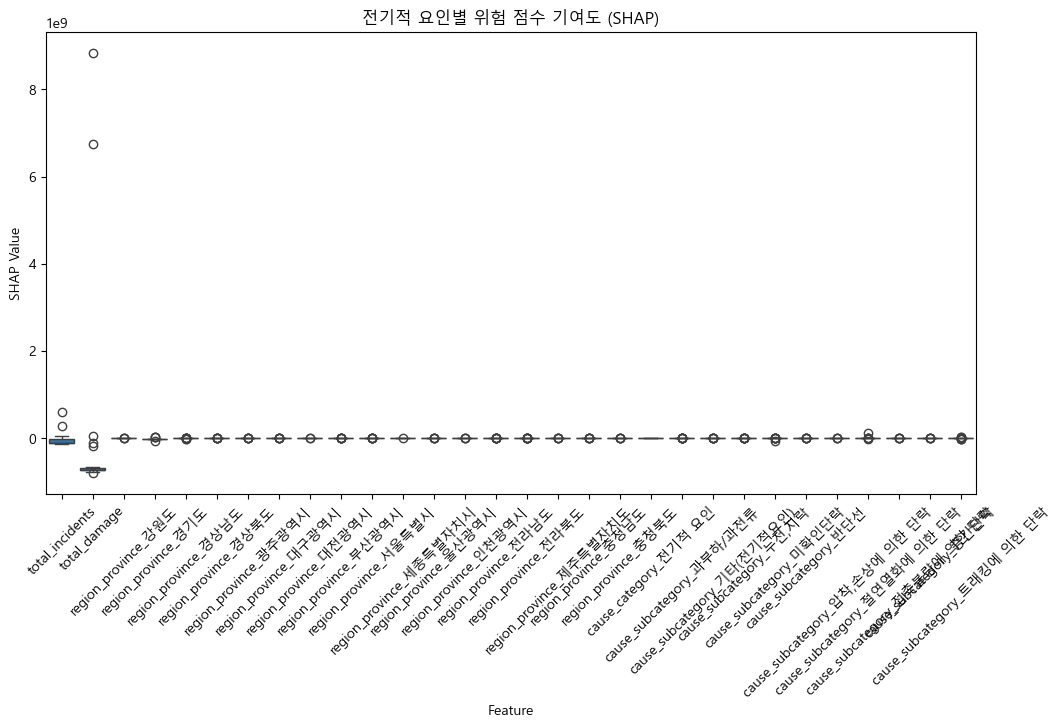

In [14]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 현재 실행 중인 스크립트의 디렉토리 기준으로 상대경로 설정
base_dir = Path.cwd()
file_path = base_dir / "electric_ai_data.csv"
print("현재 작업 디렉토리:", os.getcwd())

# 데이터 로드
data = pd.read_csv(file_path)

# 위험 점수 정의 (예측 대상)
data["risk_score"] = data["total_incidents"] * data["total_damage"]

# 모델 학습을 위한 데이터 준비
features = ["region_province", "cause_category", "cause_subcategory", "total_incidents", "total_damage"]
target = "risk_score"

# 원핫 인코딩 (범주형 데이터 변환)
data_encoded = pd.get_dummies(data[features])

X = data_encoded
y = data[target]

# 학습 / 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤포레스트 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test, check_additivity=False)

# SHAP 값을 데이터프레임으로 변환
shap_df = pd.DataFrame(shap_values, columns=X.columns)
shap_df["Region"] = data.loc[X_test.index, "region_province"]

# 방법 1: 지역별 개별 그래프 생성 (모든 전기적 세부 요인 포함)
unique_regions = shap_df["Region"].dropna().unique()
num_rows = (len(unique_regions) // 6) + 1
fig, axes = plt.subplots(nrows=num_rows, ncols=6, figsize=(20, 12))
axes = axes.flatten()

for i, region in enumerate(unique_regions):
    region_df = shap_df[shap_df["Region"] == region]
    
    if region_df.empty:
        axes[i].axis("off")
        continue
    
    mean_shap = region_df.drop(columns=["Region"]).mean().sort_values(ascending=False)  # 모든 요인 포함

    axes[i].bar(mean_shap.index, mean_shap.values)
    axes[i].set_title(region)
    axes[i].set_xticks(range(len(mean_shap.index)))
    axes[i].set_xticklabels(mean_shap.index, rotation=45, ha="right")
    axes[i].set_ylabel("위험 점수 기여도 (SHAP)")

plt.tight_layout()
plt.savefig("region_shap_graph_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

# 방법 2: SHAP 히트맵
plt.figure(figsize=(12, 8))
sns.heatmap(shap_df.drop(columns=["Region"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("SHAP 기여도 상관 관계 히트맵")
plt.savefig("shap_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# 방법 3: Boxplot (SHAP 분석 기반)
plt.figure(figsize=(12, 6))
shap_long = shap_df.melt(id_vars=["Region"], var_name="Feature", value_name="SHAP Value")
sns.boxplot(x="Feature", y="SHAP Value", data=shap_long)
plt.xticks(rotation=45)
plt.title("전기적 요인별 위험 점수 기여도 (SHAP)")
plt.savefig("shap_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()
